In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [3]:
from MMM import mmm

Importing plotly failed. Interactive plots will not work.


# 0. Data Imports

In [4]:
data = pd.read_csv("sales.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]

In [5]:
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,na,28157.000000
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,na,10644.000000
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,na,9597.000000
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,na,90189.000000


# 1. Seasonality and Trend Decomposition

To-do
- Convert to method
- Add Holidays optional holidays functionality

In [6]:
START_INDEX = 52
END_INDEX = 144

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append met

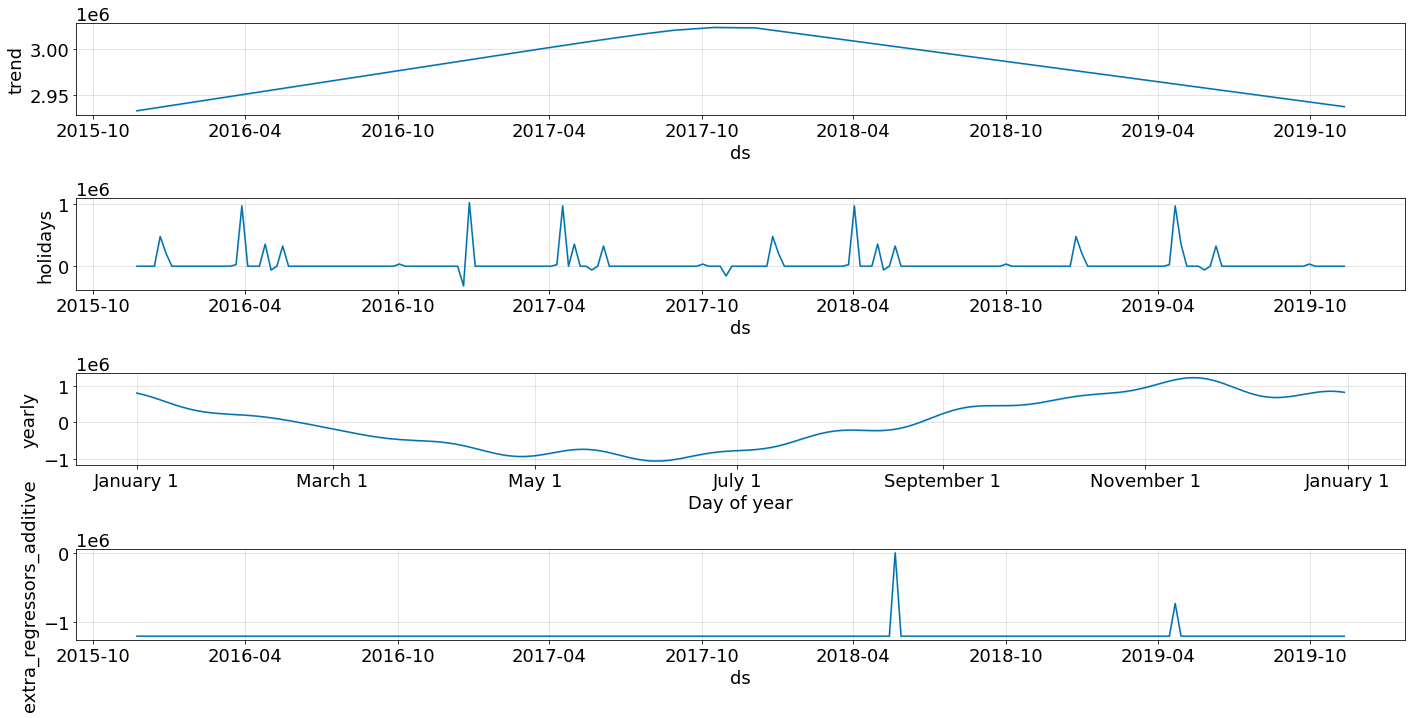

In [7]:
mm_model = mmm()
data = mm_model.decomposition(data, encode_holidays = True, 
                              encode_events = True, 
                              holidays_file = "generated_holidays.csv", 
                              country_code = "DE")
mm_model.plot_decomposition()

# 2. Spend-Exposure estimation

In [8]:
media_spend_exposure_df = mm_model.estimate_spend_exposure(data,
                                                          media_exposures = ["facebook_I", "search_clicks_P"],
                                                          media_spends = ["facebook_S", "search_S"])

# 3. Scaling and Standardization

In [9]:
#choose features/variables to normalize e.g. only independant variables. 
feature_vars = ["trend", 
                "season", 
                "holiday", 
                "competitor_sales_B", 
                "events", 
                "tv_S", 
                "ooh_S", 
                "print_S",
                "facebook_I", 
                "search_clicks_P", 
                "newsletter",
                "revenue"]

target_var = "revenue"

def normalize_data(data, feature_vars):
    data_transformed = data.copy()
    numerical_encoder_dict = {}
    
    for feature in feature_vars:
        scaler = MinMaxScaler()
        original = data[feature].values.reshape(-1, 1)
        transformed = scaler.fit_transform(original)
        data_transformed[feature] = transformed
        numerical_encoder_dict[feature] = scaler
        
    return data_transformed

In [10]:
data_transformed = normalize_data(data, feature_vars)
#data_transformed[target_var] = data[target_var].values / 100_000

# 4. PYMC3 Model

In [11]:
delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]
control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]

mm_model.initialize(data_transformed, 
                    delay_channels, 
                    media_channels, 
                    control_variables, 
                    target_var, 
                    START_INDEX = 52, 
                    END_INDEX = 144)

Delay Channels: Adding tv_S


INFO:filelock:Lock 140163587704912 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163587704912 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163588429760 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163588429760 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163587316368 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163587316368 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163590484368 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163590484368

Delay Channels: Adding ooh_S


INFO:filelock:Lock 140163605601440 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163605601440 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding print_S


INFO:filelock:Lock 140163613616688 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163613616688 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding facebook_I


INFO:filelock:Lock 140163621732512 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163621732512 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding search_clicks_P


INFO:filelock:Lock 140163629706496 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163629706496 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding newsletter


INFO:filelock:Lock 140163618618048 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163618618048 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


INFO:filelock:Lock 140163603153104 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163603153104 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163603005888 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163603005888 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163602526368 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163602526368 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163602676992 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163602676992

INFO:filelock:Lock 140163640222432 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640222432 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640223968 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640223968 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640290992 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640290992 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640223584 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163640223584

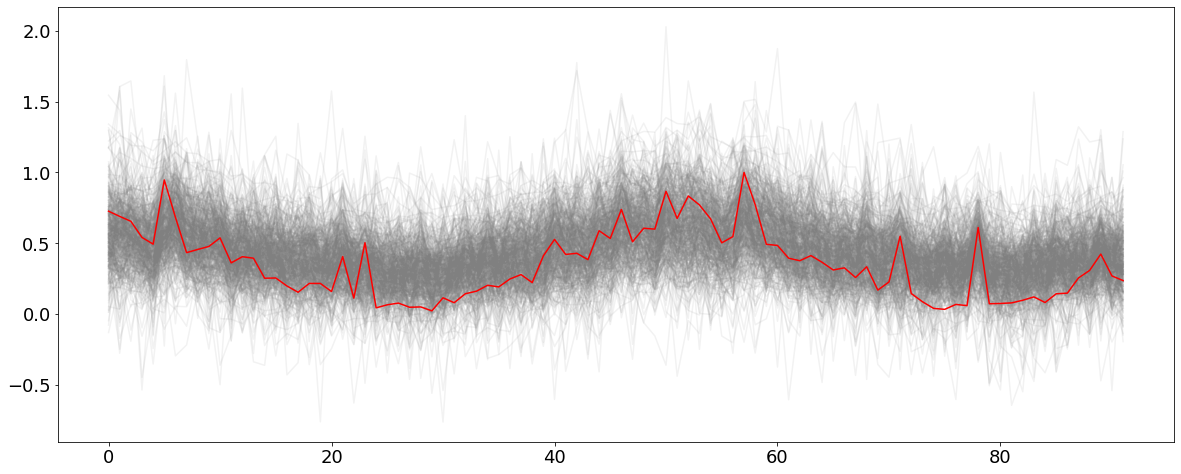

In [12]:
mm_model.plot_prior_predictive(data_transformed)

In [13]:
trace, trace_summary = mm_model.fit(draws = 1000,
                                    tune = 1000, 
                                    chains = 4, 
                                    cores = 4, 
                                    target_accept = 0.95)

INFO:filelock:Lock 140163645369840 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163645369840 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163655494384 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163655494384 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163655684160 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163655684160 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163657750416 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163657750416

INFO:filelock:Lock 140163268226640 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163268226640 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163268718496 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163268718496 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163268957856 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163268957856 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163271477040 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140163271477040

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 1062 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 1062 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [14]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,-0.124,0.022,-0.167,-0.088,0.001,0.001,408.0,328.0,1.00
season_control_coef,0.269,0.055,0.174,0.377,0.003,0.002,408.0,246.0,1.01
holiday_control_coef,0.392,0.035,0.329,0.454,0.002,0.001,360.0,293.0,1.00
competitor_sales_B_control_coef,0.394,0.059,0.280,0.501,0.003,0.002,366.0,274.0,1.02
events_control_coef,0.330,0.050,0.245,0.424,0.003,0.002,391.0,340.0,1.00
tv_S_adstock,0.296,0.119,0.095,0.518,0.006,0.005,503.0,179.0,1.03
tv_S_gamma,0.283,0.171,0.088,0.648,0.018,0.013,256.0,172.0,1.05
tv_S_alpha,2.777,1.425,0.874,5.238,0.080,0.057,321.0,408.0,1.01
tv_S_media_coef,0.129,0.044,0.062,0.223,0.002,0.002,317.0,346.0,1.02
ooh_S_adstock,0.495,0.186,0.174,0.811,0.008,0.006,508.0,336.0,1.00


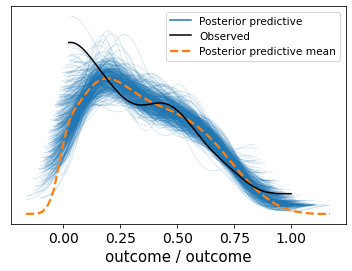

In [15]:
mm_model.plot_posterior_predictive()

In [25]:
mm_model.fit_metrics(data_transformed)

RMSE: 0.05484172753581007
MAPE: 0.17821140905152985
NRMSE: 0.056159205270780006


# 5. Decomposition

In [26]:
#Apply media transformations on data with optimized parameters.
data_transformed_decomposed = mm_model.apply_transformations(data_transformed)

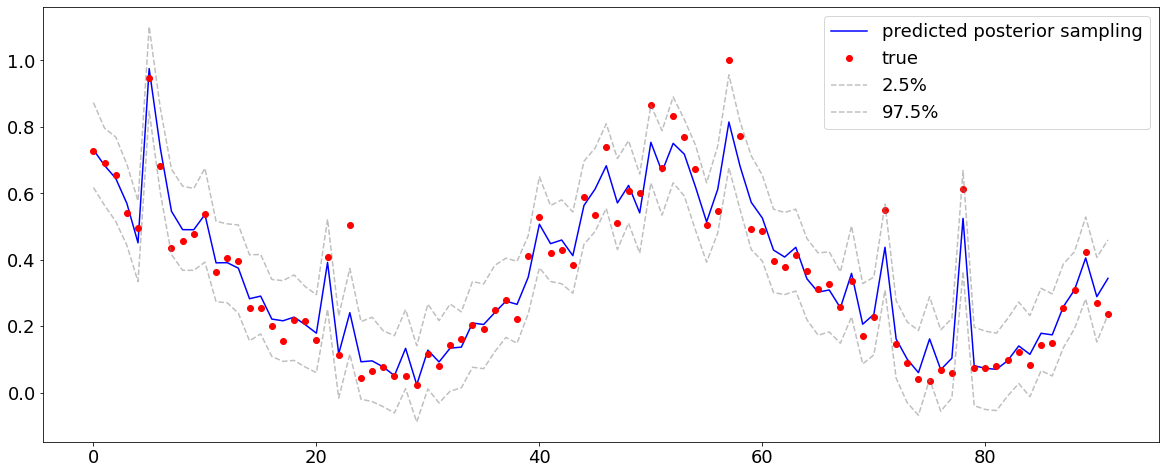

In [27]:
mm_model.plot_model_fit(data_transformed_decomposed)

In [28]:
#Test accuracies
predictions = mm_model.predict(data_transformed_decomposed, 144, 156, return_metrics = True)

RMSE: 0.06765424551926419
MAPE: 0.12101079677608871
NRMSE: 0.16751432362239513


In [29]:
spend_response_share_df = mm_model.compute_spend_effect_share(data, data_transformed_decomposed, media_spend_exposure_df)

In [30]:
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,tv_S,1.024794e+07,0.293475,1.948804,0.356608
1,ooh_S,1.024054e+07,0.293263,0.495720,0.090711
2,print_S,2.793216e+06,0.079991,0.806306,0.147545
3,facebook_I,6.146199e+06,0.176012,0.380052,0.069545
4,search_clicks_P,3.625151e+06,0.103815,1.181667,0.216231
5,newsletter,1.866242e+06,0.053444,0.652279,0.119359


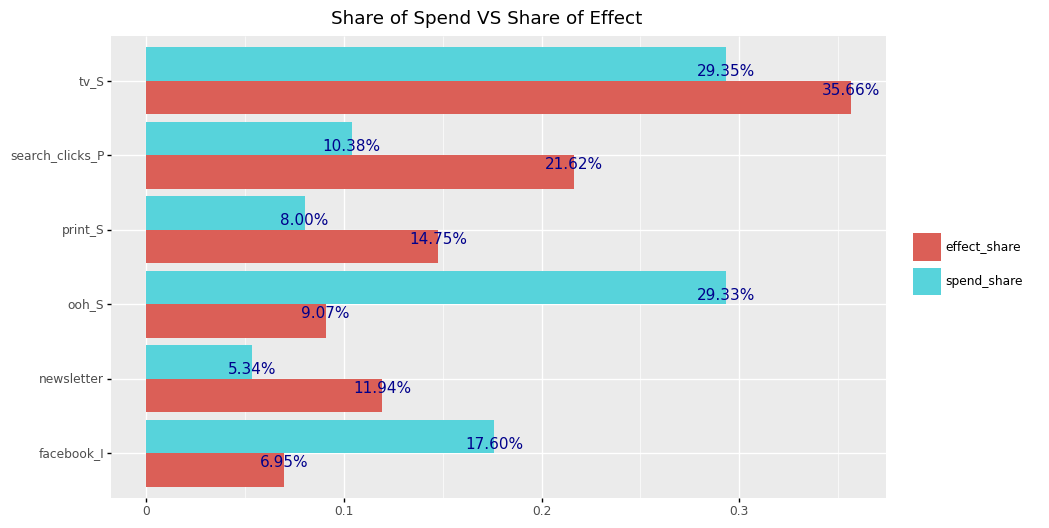

<ggplot: (8760209405492)>

In [31]:
mm_model.plot_spend_vs_effect_share(spend_response_share_df)